In [1]:
import numpy as np
import matplotlib.pyplot as plt
import saqqara
from simulator import LISA_AET
import glob
import torch
import swyft
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from pytorch_lightning import loggers as pl_loggers

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
config = saqqara.load_settings("default_config.yaml")
sim = LISA_AET(config)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


In [3]:
from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel

class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, sim=None, learning_rate=1e-5):
        super().__init__()
        self.sim = sim
        self.learning_rate = learning_rate
        self.early_stopping_patience = 100
        self.num_feat_param = 3  # Number of channels
        self.num_params = 2
        self.npts = sim.coarse_grained_f.shape[0]
        #self.npts = 650
        self.nl_AA = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_AA_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.resnet = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.resnet_no_log = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.fc_AA = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_EE = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_TT = torch.nn.Linear(self.npts, sim.nparams)
        self.marginals = self.get_marginals(self.num_params)
        self.lrs1d = swyft.LogRatioEstimator_1dim(
            #num_features=self.num_feat_param,
            num_features=2 * self.num_feat_param * self.num_params,
            num_params=self.num_params,
            varnames="z",
            num_blocks=3,
            hidden_features=64,
            dropout=0.1,
        )
        self.lrs2d = swyft.LogRatioEstimator_Ndim(
            #num_features=2 * self.num_feat_param,
            num_features=2 * self.num_feat_param * self.num_params,
            marginals=self.marginals,
            num_blocks=3,
            hidden_features=64,
            varnames="z",
            dropout=0.1,
        )

    def forward(self, A, B):
        log_data = torch.log(A["data"])
        # reshape to (batch, num_channels, num_freqs)
        log_data = log_data.transpose(1, 2)
        norm_AA = self.nl_AA(log_data[..., 0, :])
        norm_EE = self.nl_EE(log_data[..., 1, :])
        norm_TT = self.nl_TT(log_data[..., 2, :])

        full_data = torch.stack([norm_AA, norm_EE, norm_TT], dim=-2)
        no_log_data = torch.exp(full_data)
        norm_AA_nolog = self.nl_AA_nolog(no_log_data[..., 0, :])
        norm_EE_nolog = self.nl_EE_nolog(no_log_data[..., 1, :])
        norm_TT_nolog = self.nl_TT_nolog(no_log_data[..., 2, :])
        no_log_data = torch.stack([norm_AA_nolog, norm_EE_nolog, norm_TT_nolog], dim=-2)

        compression = self.resnet(full_data)
        no_log_compression = self.resnet_no_log(no_log_data)
        s1 = compression.reshape(-1, self.num_params * self.num_feat_param)
        s2 = no_log_compression.reshape(-1, self.num_params * self.num_feat_param)
        s = torch.cat((s1, s2), dim=1)
        # lrs1d = self.lrs1d(s, B["z"][:, :2])
        lrs2d = self.lrs2d(s, B["z"][:, :2])
        #return lrs1d, lrs2d
        return lrs2d

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j > i:
                    marginals.append((i, j))
        return tuple(marginals)

In [4]:
device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = swyft.SwyftTrainer(accelerator=device, max_epochs=100, logger=None)
network = InferenceNetwork(sim=sim, learning_rate=1e-5)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
prior_samples = sim.sample(1_000_000, targets=["z"])

100%|██████████| 1000000/1000000 [00:11<00:00, 83779.66it/s]


In [6]:
def load_network_state(network, checkpoint):
    state_dict = torch.load(checkpoint)['state_dict']
    network.load_state_dict(state_dict)
    return network

In [7]:
ckpt_dict = {
    '1M_1e-5_2048': './saqqara/ae6mjehp/checkpoints/epoch=96-step=37830.ckpt',
    '50000_0.0001_64': './saqqara/k3yqqgcz/checkpoints/epoch=88-step=55625.ckpt',
    '50000_5e-05_64': './saqqara/crcqdubc/checkpoints/epoch=87-step=55000.ckpt',
    '50000_1e-05_64': './saqqara/i87us0w0/checkpoints/epoch=97-step=61250.ckpt',
    '20000_1e-05_128': './saqqara/koyz6v9y/checkpoints/epoch=67-step=8500.ckpt', 
    '20000_1e-05_64': './saqqara/j4nmxm4h/checkpoints/epoch=96-step=24250.ckpt',
    '20000_1e-05_32': './saqqara/wq43aicn/checkpoints/epoch=58-step=29500.ckpt',
    '20000_0.0001_64': './saqqara/nkp3i98w/checkpoints/epoch=99-step=25000.ckpt',
    '20000_5e-5_64': './saqqara/wgdhw0tk/checkpoints/epoch=95-step=24000.ckpt',
    '20000_1e-5_64': './saqqara/x6lfrkzq/checkpoints/epoch=96-step=24250.ckpt',
    '10000_1e-05_128': './saqqara/ongmd6n2/checkpoints/epoch=97-step=6076.ckpt', 
    '10000_1e-05_64': './saqqara/dz6szirw/checkpoints/epoch=89-step=11250.ckpt',
    '10000_1e-05_32': './saqqara/flj8o6f0/checkpoints/epoch=78-step=19750.ckpt',
    '10000_0.0001_64': './saqqara/ssck4ofm/checkpoints/epoch=92-step=11625.ckpt',
    '10000_5e-5_64_64': './saqqara/wovil04p/checkpoints/epoch=89-step=11250.ckpt',
    '10000_1e-5_64': './saqqara/e3asj75g/checkpoints/epoch=96-step=12125.ckpt',
}

hex_colors = {
    '1M_1e-5_2048': '#1f77b4',
    '50000_0.0001_64': '#aec7e8',
    '50000_5e-05_64': '#ff7f0e',
    '50000_1e-05_64': '#2ca02c',
    '20000_1e-05_128': '#98df8a',
    '20000_1e-05_64': '#d62728',
    '20000_1e-05_32': '#9467bd',
    '20000_0.0001_64': '#c5b0d5',
    '20000_5e-5_64': '#8c564b',
    '20000_1e-5_64': '#e377c2',
    '10000_1e-05_128': '#f7b6d2',
    '10000_1e-05_64': '#7f7f7f',
    '10000_1e-05_32': '#bcbd22',
    '10000_0.0001_64': '#dbdb8d',
    '10000_5e-5_64_64': '#17becf',
    '10000_1e-5_64': '#9edae5',
}

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)


50000_0.0001_64 - #aec7e8


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.14it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


50000_5e-05_64 - #ff7f0e
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s]
50000_1e-05_64 - #2ca02c


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.68it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


20000_1e-05_128 - #98df8a
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.90it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


20000_1e-05_64 - #d62728
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


20000_1e-05_32 - #9467bd
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


20000_0.0001_64 - #c5b0d5
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


20000_5e-5_64 - #8c564b
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.65it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


20000_1e-5_64 - #e377c2
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.76it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10000_1e-05_128 - #f7b6d2
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10000_1e-05_64 - #7f7f7f
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10000_1e-05_32 - #bcbd22
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10000_0.0001_64 - #dbdb8d
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.64it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10000_5e-5_64_64 - #17becf
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.60it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10000_1e-5_64 - #9edae5
Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  9.02it/s]


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s]
1M_1e-5_2048 - #1f77b4
50000_0.0001_64 - #aec7e8
50000_5e-05_64 - #ff7f0e
50000_1e-05_64 - #2ca02c
20000_1e-05_128 - #98df8a
20000_1e-05_64 - #d62728
20000_1e-05_32 - #9467bd
20000_0.0001_64 - #c5b0d5
20000_5e-5_64 - #8c564b
20000_1e-5_64 - #e377c2
10000_1e-05_128 - #f7b6d2
10000_1e-05_64 - #7f7f7f
10000_1e-05_32 - #bcbd22
10000_0.0001_64 - #dbdb8d
10000_5e-5_64_64 - #17becf
10000_1e-5_64 - #9edae5


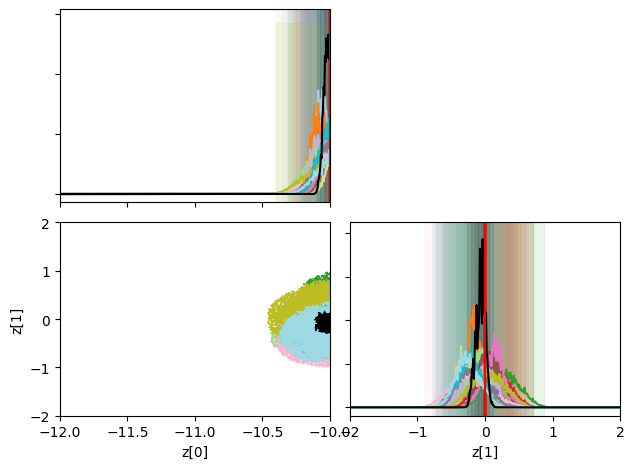

In [8]:
observation = sim.sample(conditions={"z": np.array([-10., 0.0, 3., 15.])})
observation["data"] = torch.tensor(observation["coarse_grained_data"])
dict_keys = list(observation.keys())
for k in dict_keys:
    if k not in ["z", "data"]:
        observation.pop(k)
colors = ['red', 'blue', 'green', 'orange', 'purple']
idx = 0
for run in list(ckpt_dict.keys()):
    if run != '1M_1e-5_2048':
        ckpt = ckpt_dict[run]
        c = hex_colors[run]
        print(run, "-", c)
        net = load_network_state(network, ckpt)
        logratios = trainer.infer(net, observation, prior_samples, batch_size=32000)
        if idx != 0:
            swyft.plot_corner(logratios, parnames=[f"z[{idx}]" for idx in range(2)], bins=1000, fig=plt.gcf(), color=c)
        else:
            swyft.plot_corner(logratios, parnames=[f"z[{idx}]" for idx in range(2)], bins=1000, color=c);
        for j in range(2):
            ax = plt.subplot(2, 2, 2 * j + j + 1)
            plt.axvline(observation["z"][j], c="r")
        idx += 1
net = load_network_state(network, './saqqara/ae6mjehp/checkpoints/epoch=96-step=37830.ckpt') # 1M model
logratios = trainer.infer(net, observation, prior_samples, batch_size=32000)
swyft.plot_corner(logratios, parnames=[f"z[{idx}]" for idx in range(2)], bins=1000, color='black', fig=plt.gcf())
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
ax = plt.subplot(2, 2, 1)
plt.xlim(-12, -10)
ax = plt.subplot(2, 2, 3)
plt.xlim(-12, -10)
plt.ylim(-2, 2)
ax = plt.subplot(2, 2, 4)
plt.xlim(-2, 2)
for run in list(ckpt_dict.keys()):
    print(run, "-", hex_colors[run])

In [32]:
def get_samples(N, a_low, a_high, g_low, g_high, A_low, A_high, P_low, P_high):
    a_sample = np.random.uniform(a_low, a_high, N)
    g_sample = np.random.uniform(g_low, g_high, N)
    A_sample = np.random.uniform(A_low, A_high, N)
    P_sample = np.random.uniform(P_low, P_high, N)
    z_sample = np.float32(np.vstack((a_sample, g_sample, A_sample, P_sample)).T)
    return swyft.Samples(z=z_sample)


In [10]:
high_dim_prior_samples = sim.sample(10_000_000, targets=["z"])

  0%|          | 15664/10000000 [00:00<02:06, 79087.32it/s]

100%|██████████| 10000000/10000000 [01:59<00:00, 83377.52it/s]


In [33]:
p_samples = get_samples(10000000, -10.2, -9.8, -0.3, 0.3, 3.0, 3.0, 15.0, 15.0)
logratios_zoom = trainer.infer(net, observation, p_samples, batch_size=32000)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 313/313 [00:40<00:00,  7.65it/s]


In [12]:
logratios_low_dim = trainer.infer(net, observation, prior_samples, batch_size=64000)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]


In [22]:
torch.max(logratios.logratios[:, 0])

tensor(9.5364)

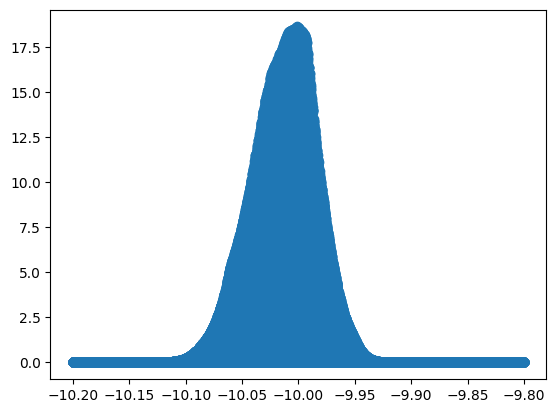

In [28]:
weights = np.exp(logratios_zoom.logratios[::100, 0] - torch.max(logratios.logratios[:, 0]))
plt.scatter(logratios_zoom.params[::100, 0, 0], weights / weights.sum() * len(weights))

(-0.3, 0.3)

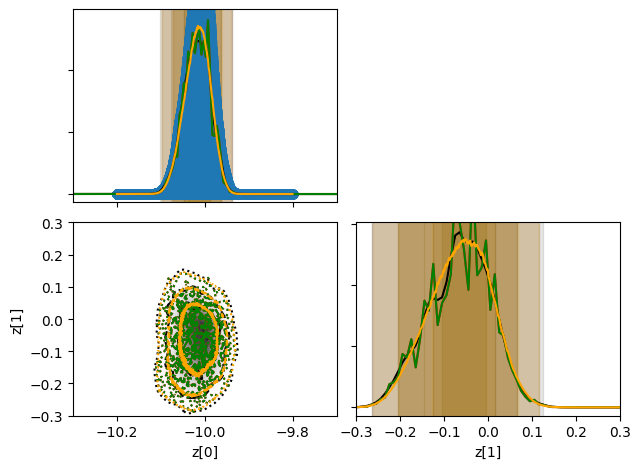

In [35]:
swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=1.3);
swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, fig=plt.gcf(), color='red');
swyft.plot_corner(logratios_low_dim, parnames=logratios.parnames[0], bins=1000, fig=plt.gcf(), color='green');
swyft.plot_corner(logratios_zoom, parnames=logratios.parnames[0], bins=1000, fig=plt.gcf(), color='orange', smooth=1.3);
ax = plt.subplot(2, 2, 1)
weights = np.exp(logratios_zoom.logratios[::100, 0] - torch.max(logratios_zoom.logratios[:, 0]))
plt.scatter(logratios_zoom.params[::100, 0, 0], weights / weights.sum() * len(weights))
plt.xlim(-10.3, -9.7)
ax = plt.subplot(2, 2, 3)
plt.xlim(-10.3, -9.7)
plt.ylim(-0.3, 0.3)
ax = plt.subplot(2, 2, 4)
plt.xlim(-0.3, 0.3)